### 1. 구현 초기 설정

In [2]:
import glob
import os.path as osp
import random
import numpy as np 
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

torch.cuda.manual_seed(1234) # gpu 사용
torch.cuda.manual_seed_all(1234) # 멀티 gpu 사용

### 2. 데이터셋 작성

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

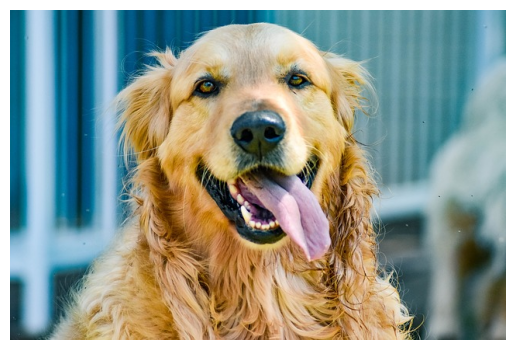

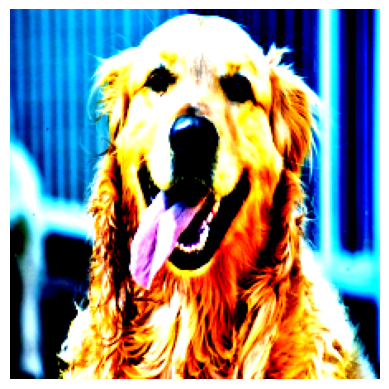

In [7]:
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.axis('off')
plt.show()

size = 224
mean = (0.484, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.axis('off')
plt.show()

In [10]:
def make_datapath_list(phase='train'):
    rootpath = './data/hymenoptera_data/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path) 
    
    return path_list

train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [15]:
class HymenopteraDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)

        if self.phase == 'train':
            label = img_path[30:34]
        elif self.phase == 'val':
            label = img_path[28:32]
    
        if label == 'ants':
            label = 0
        elif label == 'bees':
            label = 1
        
        return img_transformed, label

train_dataset = HymenopteraDataset(file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = HymenopteraDataset(file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


### 3. 데이터 로더 작성

In [43]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# 동작확인
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 0])


### 4. 네트워크 모델 작성

In [44]:
from torchvision.models import VGG16_Weights

use_pretrained = True
net = models.vgg16(weights=VGG16_Weights.DEFAULT)

net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


### 5. 손실함수 정의

In [45]:
criterion = nn.CrossEntropyLoss()

### 6. 최적화 기법 설정

In [46]:
# 학습시킬 파라미터 저장 변수
params_to_update = []

# 학습시킬 파라미터명
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requries_grad = False
        
print('------------')
print(params_to_update)

classifier.6.weight
classifier.6.bias
------------
[Parameter containing:
tensor([[-0.0097, -0.0110, -0.0037,  ..., -0.0129, -0.0024,  0.0130],
        [ 0.0022, -0.0088,  0.0090,  ...,  0.0050,  0.0119,  0.0031]],
       requires_grad=True), Parameter containing:
tensor([-0.0152, -0.0102], requires_grad=True)]


In [47]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

### 7. 학습 및 검증 실시

In [48]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------------')
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            # 학습하지 않을 시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch ==0) and (phase == 'train'):
                continue
            
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                optimizer.zero_grad()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1) # 라벨 예측    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # 반복 결과 계산
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += preds.eq(labels.view_as(preds)).sum().item()

            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects / len(dataloaders_dict[phase].dataset)
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [49]:
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(net.to(device), dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/2
-------------------


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


val Loss: 0.6718 Acc: 0.5425
Epoch 2/2
-------------------


100%|██████████| 8/8 [00:03<00:00,  2.39it/s]


train Loss: 0.4548 Acc: 0.7819


100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

val Loss: 0.1745 Acc: 0.9673
